### Car Insurance Cold Calls
***
#### **Overview**: 
##### This notebook walks through exploratory data analysis (EDA), model training and evaluation of the cold call car insurance campaign.
***
#### **Aim**:
##### Build a classifier to most accurately predict which customer will buy car insurance or not
***
###### ***Notebook Spec***: JupyterLab running a Python 3.7.2 kernel

In [28]:
# import packages

# user-defined py files
import env

# python standard packages
import pandas as pd
import numpy as np
import logging
logging.basicConfig(level=logging.INFO, filename = env.logger_path, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S') 
# creating the log file is really only useful in production - in a notebook, print statements make more sense but wanted show that it is important
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency
sns.set(rc={'figure.figsize': (12, 8)}) # set plotting params

In [2]:
# import train and test data
df_train = pd.read_csv(env.train_data)
df_test = pd.read_csv(env.test_data)
logging.info('train and test data read in')

## Exploratory Data Analysis 

##### First, let's explore the data 

In [3]:
# view list of vars in train data
df_train.dtypes, df_train.shape

(Id                   int64
 Age                  int64
 Job                 object
 Marital             object
 Education           object
 Default              int64
 Balance              int64
 HHInsurance          int64
 CarLoan              int64
 Communication       object
 LastContactDay       int64
 LastContactMonth    object
 NoOfContacts         int64
 DaysPassed           int64
 PrevAttempts         int64
 Outcome             object
 CallStart           object
 CallEnd             object
 CarInsurance         int64
 dtype: object, (4000, 19))

In [4]:
# view first few rows, id = Id, target variable = CarInsurance
df_train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [5]:
# quick inspect of the train data, include all data types
include_vars =['object', 'float', 'int']
df_train.describe(include = include_vars)

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
count,4000.000000,4000.000000,3981,4000,3831,4000.000000,4000.000000,4000.00000,4000.000000,3098,4000.000000,4000,4000.000000,4000.000000,4000.000000,958,4000,4000,4000.000000
unique,NaN,NaN,11,3,3,NaN,NaN,NaN,NaN,2,NaN,12,NaN,NaN,NaN,3,3777,3764,NaN
top,NaN,NaN,management,married,secondary,NaN,NaN,NaN,NaN,cellular,NaN,may,NaN,NaN,NaN,failure,17:11:04,10:22:30,NaN
freq,NaN,NaN,893,2304,1988,NaN,NaN,NaN,NaN,2831,NaN,1049,NaN,NaN,NaN,437,3,3,NaN
mean,2000.500000,41.214750,NaN,NaN,NaN,0.014500,1532.937250,0.49275,0.133000,NaN,15.721250,NaN,2.607250,48.706500,0.717500,NaN,NaN,NaN,0.401000
std,1154.844867,11.550194,NaN,NaN,NaN,0.119555,3511.452489,0.50001,0.339617,NaN,8.425307,NaN,3.064204,106.685385,2.078647,NaN,NaN,NaN,0.490162
min,1.000000,18.000000,NaN,NaN,NaN,0.000000,-3058.000000,0.00000,0.000000,NaN,1.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
25%,1000.750000,32.000000,NaN,NaN,NaN,0.000000,111.000000,0.00000,0.000000,NaN,8.000000,NaN,1.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
50%,2000.500000,39.000000,NaN,NaN,NaN,0.000000,551.500000,0.00000,0.000000,NaN,16.000000,NaN,2.000000,-1.000000,0.000000,NaN,NaN,NaN,0.000000
75%,3000.250000,49.000000,NaN,NaN,NaN,0.000000,1619.000000,1.00000,0.000000,NaN,22.000000,NaN,3.000000,-1.000000,0.000000,NaN,NaN,NaN,1.000000


In [6]:
# count the nulls in each column
df_train.isnull().sum(axis = 0)

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

#### Observations
At a glance, the training data contains 19 variables and 4k rows. Each row represents contacting a member about car insurance. There is **demographic** information like age, job and education status. There is more specific **bank information** like average annual balance, whether they have defaulted and if they have other bank products. Finally, there is information about **marketing campaigns** and if they have successfully sold them car insurance. The data are well populated except for `Outcome`, `Job`, `Education` and `Communication`. Imputation will need to be considered for these variables. **Target:** `CarInsurance`. Next it is useful to 
1. Inspect the variables' distribution (univariate analysis)
2. Test for multicollinearity
3. Test the relationship with the target variable (bivariate analysis).

#### 1. View the variables' distributions, starting with numeric data

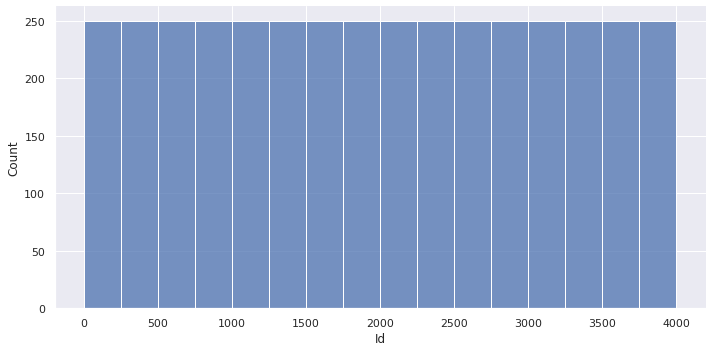

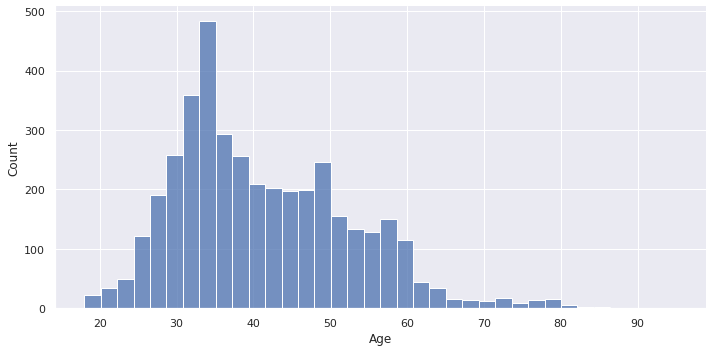

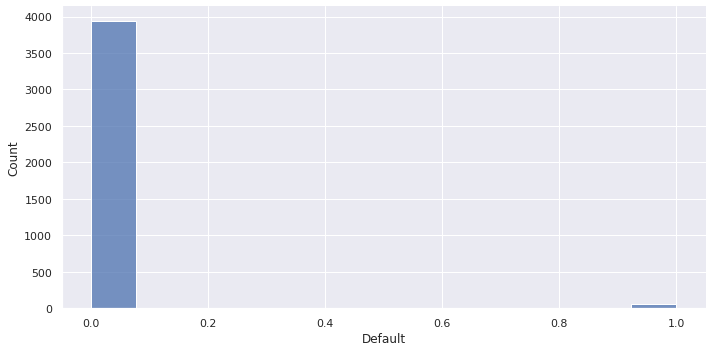

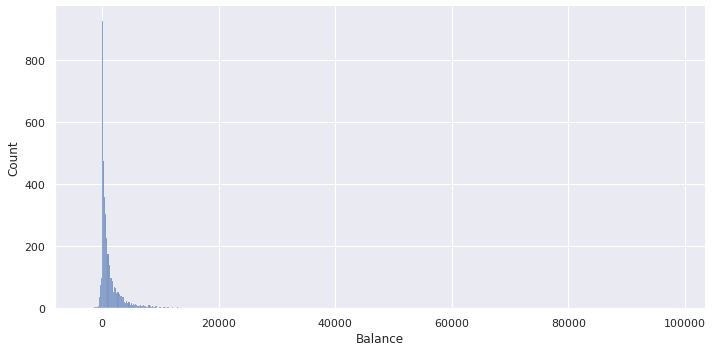

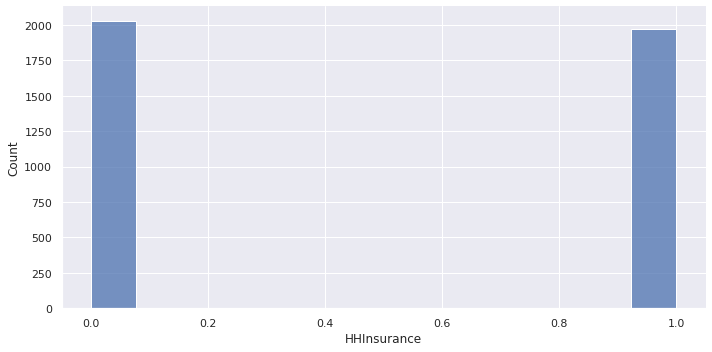

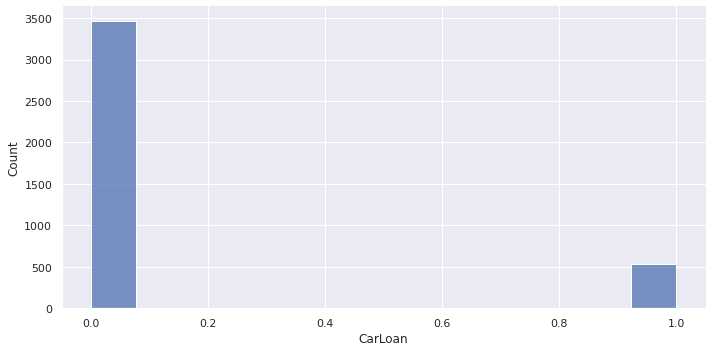

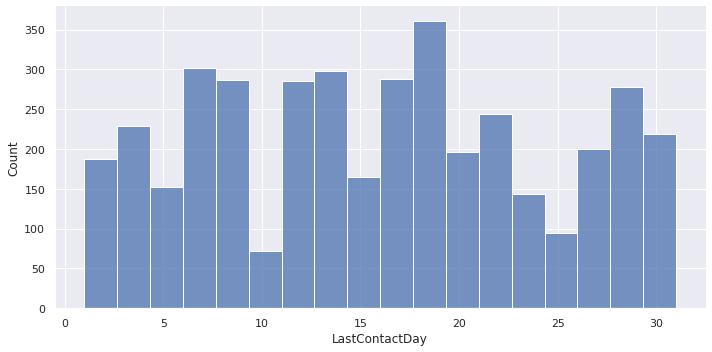

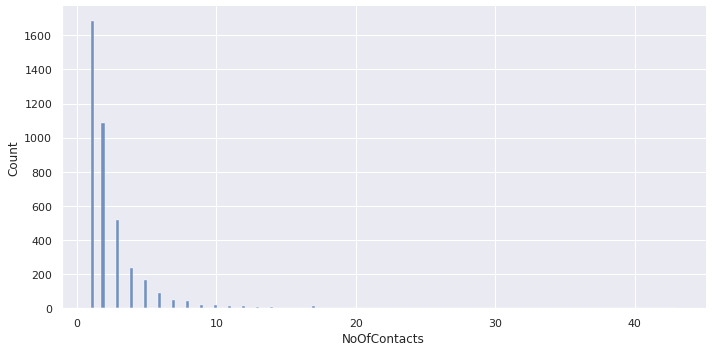

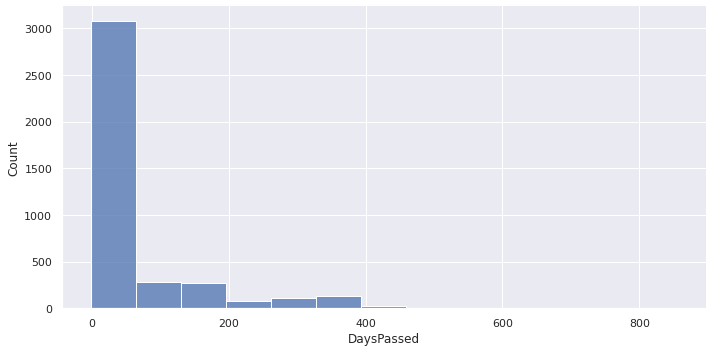

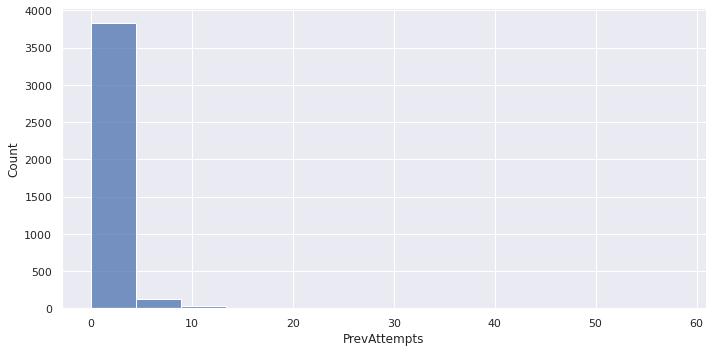

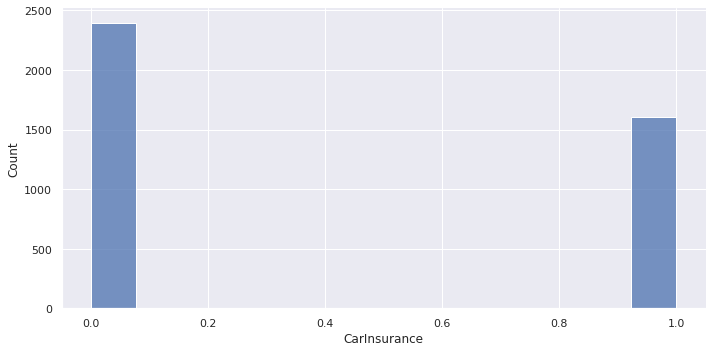

In [7]:
# get numeric variables only and create new df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df_train.select_dtypes(include=numerics)

# get distributions 
for col in df_num.columns:
    sns.displot(x = df_num[col], height = 5, aspect = 2)
    plt.show()

#### View the categorical variables' bar plot


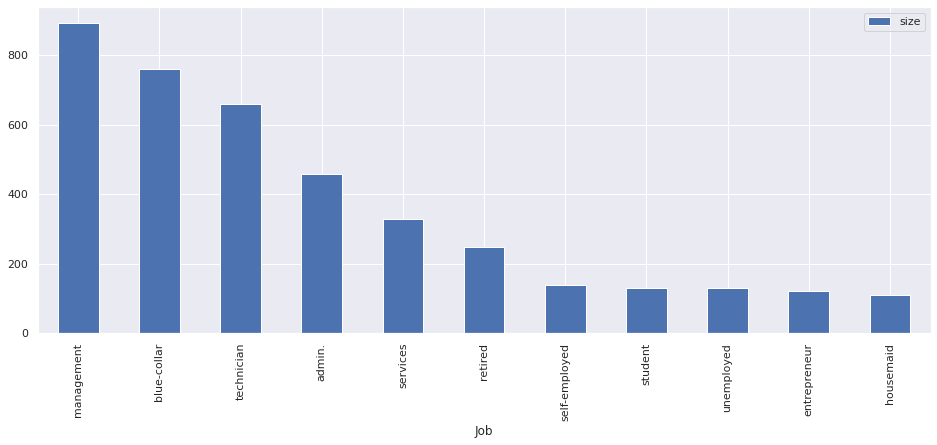

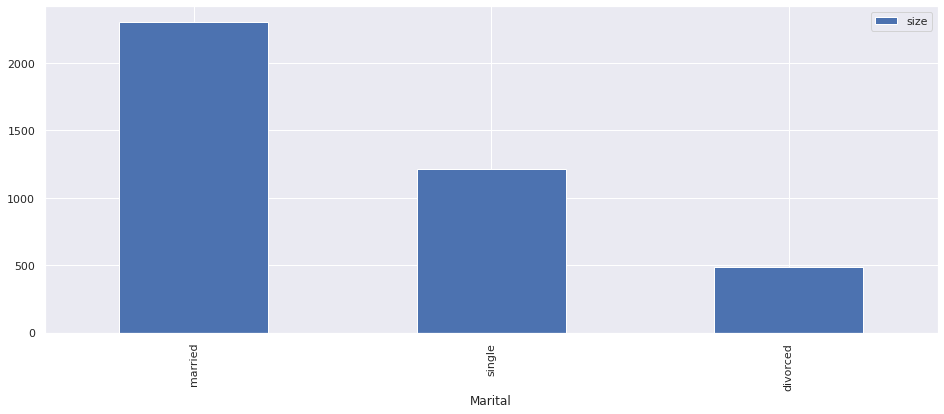

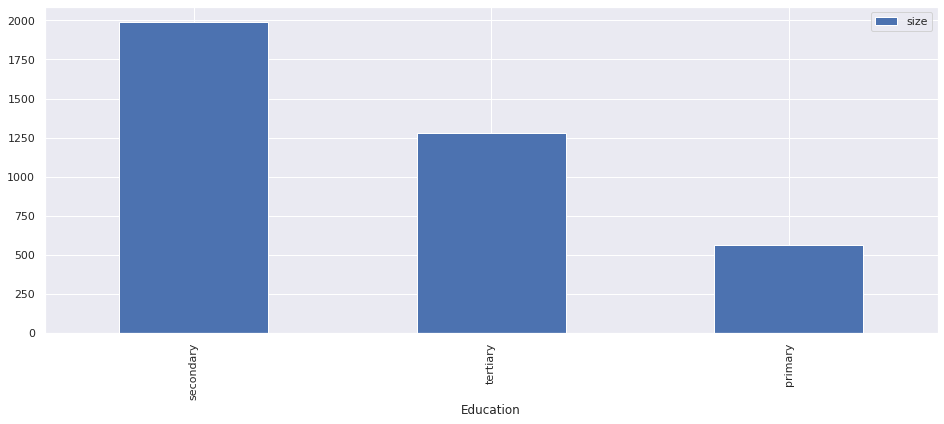

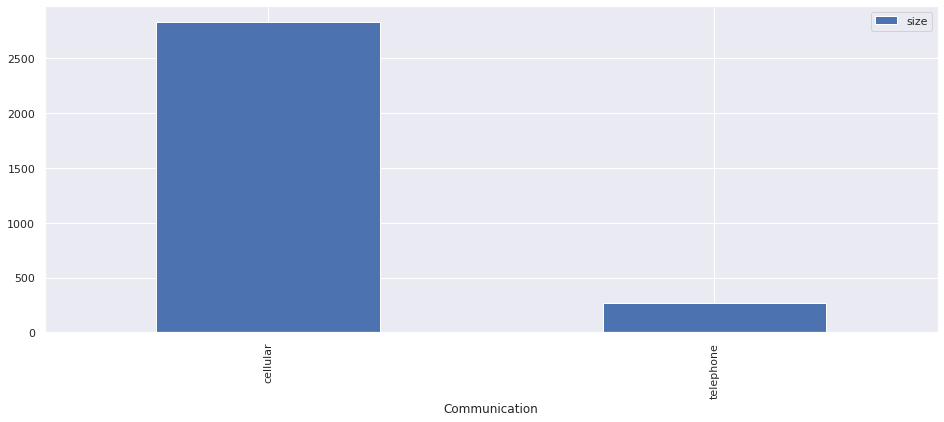

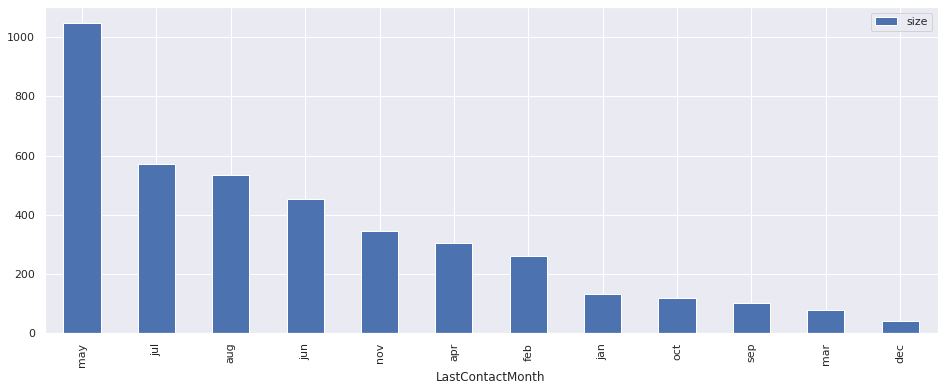

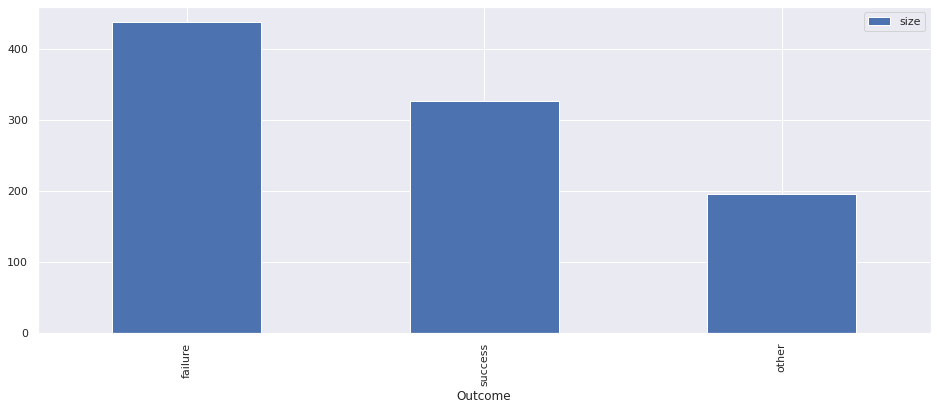

In [8]:
# create categorical dataframe
df_cat = df_train.select_dtypes(exclude=numerics)

# drop CallStart and CallEnd vars because of their high uniqueness
df_cat2 = df_cat.drop(['CallStart', 'CallEnd'], axis = 1)
for col in df_cat2.columns:
    grpd = df_cat2.groupby([col]).size().to_frame('size').reset_index()
    res = grpd.sort_values(by='size', ascending = False)
    res.plot(kind = 'bar', x = res.columns[0], figsize = (16,6))
    plt.show()

#### Univariate Observations
##### **Numerical Data**
- The `Id` var is obviously a useless predictive feature and will not be used in the model
- Many of the numerical variables are right-skewed (`Age`, `Balance`, `NoOfContacts`) and may need to be transformed or have the outliers removed
- Vars that describe previous campaigns contain imputed values e.g. `DaysPassed`
- There is a class imbalance in the target variable and may need to be resampled for model build, and/or can specifically focus on tree-based models only
- There are binary variables in the numerical data - `Default`, `HHInsurance`, `CarLoan`

##### **Categorical Data**
- `LastContactMonth` is oddly high for month of May but may be due to sampling 
- Most of the data falls into the Cellular category for `Communication` var so may have poor predictive power

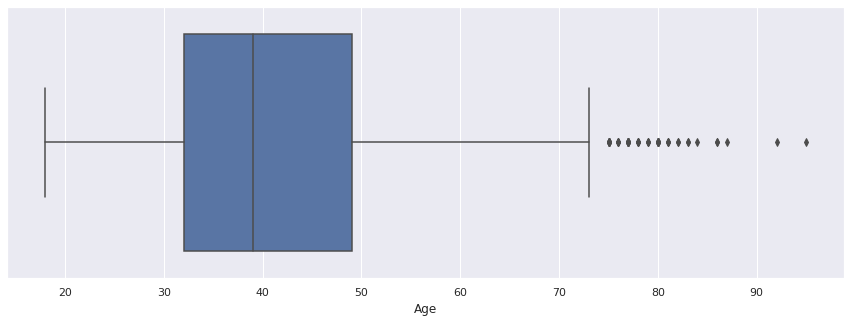

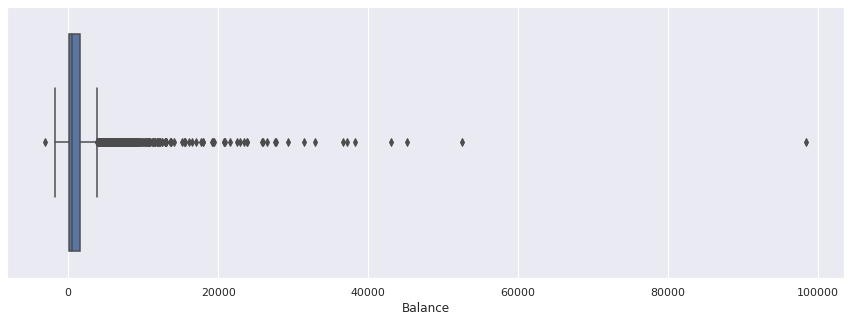

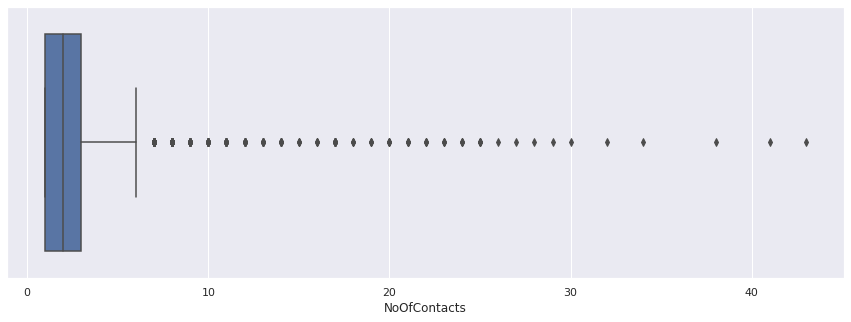

In [9]:
# check if outliers exist using box plots
check_cols = ['Age', 'Balance', 'NoOfContacts']
for col in df_train[check_cols]:
    sns.set(rc={'figure.figsize':(15,5)})
    sns.boxplot(x = df_train[col] )
    plt.show()

There are outliers in all three variables but there is an extreme outlier in the `Balance` variable. Since there is no scarity of data, the observation can be removed. The other observations can remain in the data for now. If model performance is poor, we can identify the predictions for these observations and check if they are being misclassified

(3999, 19)


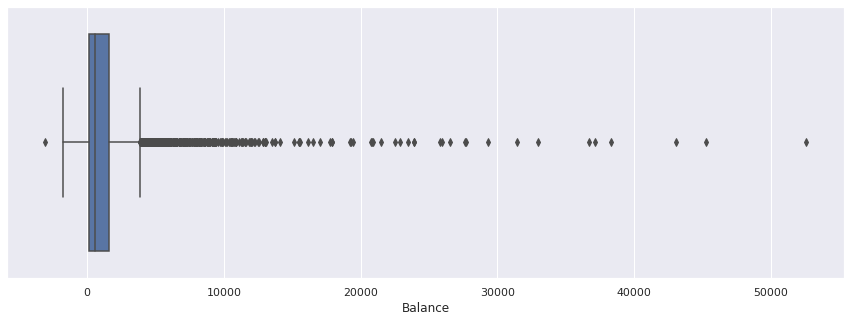

In [10]:
# find index of the large value
idx = df_train.index[df_train['Balance'] > 90000].tolist()

# delete row from table
df_train.drop(idx, axis = 0, inplace = True)
print(df_train.shape)
logging.info('outliers removed')

# replot the data to check this effect
sns.boxplot(x = df_train['Balance'])
plt.show()

Can now see that the x-axis is much smaller in its range after the extreme outlier has been removed

#### 2. Test for multicollinearity
#### 3. Test the relationship with the target variable

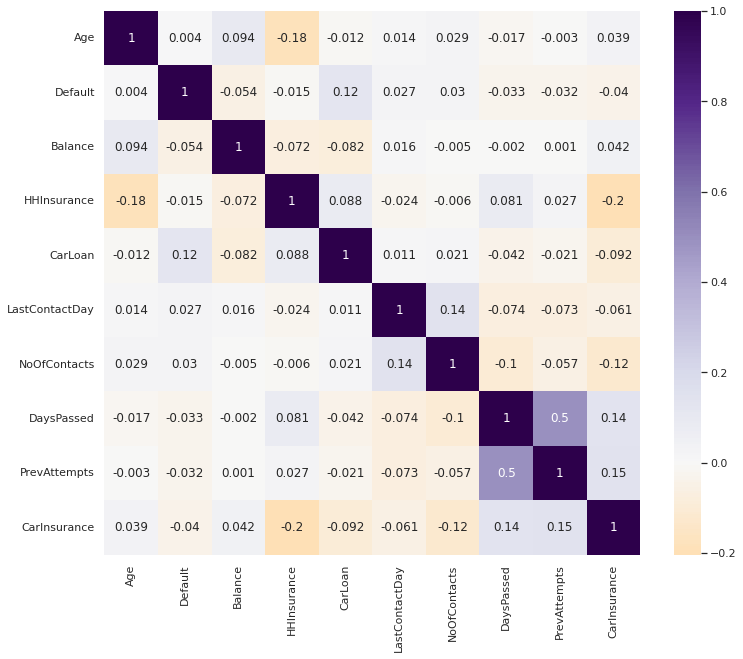

In [13]:
# linear correlation (multicollinearity)
# create linear correlation matrix, drop the Id var and round to 3 decimal places
corr_mat = df_num.corr('pearson')
corr_mat2 = corr_mat.drop(['Id'],axis=1).drop(['Id'],axis = 0).round(3)

# create plot
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(data=corr_mat2, vmax=1, annot = True, cmap="PuOr", center=0 )
plt.show()

- `DaysPassed` and `PrevAttempts` look correlated. This makes sense since both vars describe previous campaigns. Vast majority (>75%) of the customers in this data were not previously contacted so expect these two vars to be correlated for these customers. Need to consider how to handle these variables
- `PrevAttempts` and `DaysPassed` were positively correlated (weak) with the target - is this because they were longer with the bank and have better engagement with the bank?
- `HHInsurance` was negatively correlated (weak) with the target - is this because they have already bundled car and home insurance?
- The remaining variables have a very weak relationship with the target

In [26]:
# bivariate testing non-para
# kruskal_result_ls = []
# #cbrt_cols = [col for col in df_abt if col.startswith('cbrt_')]
# for num_var in df_num.columns:
#     # K Testing 
#     buy = df_num[df_num['CarInsurance'] == 0][num_var] # Split feature data by good and bad
#     nobuy = df_num[df_num['CarInsurance'] == 1][num_var]
#     k_result = kruskal(buy, nobuy)
#     print(k_result)
#     mean = df_num.groupby('CarInsurance').agg({num_var: 'mean'}).reset_index()
#     row = pd.DataFrame({'Response': 'target',
#                         'Feature': num_var,
#                         'Mean_CarInsurance': float(mean[mean['CarInsurance']==0][num_var]),
#                         'Mean_NoCarInusrance': mean[mean['CarInsurance']==1][num_var],
#                         'Kruskal_statistic': k_result.statistic,
#                         'Kruskal_pvalue': k_result.pvalue})
#     kruskal_result_ls.append(row)

#     # Boxplot by Bad
#     sns.set(rc={'figure.figsize':(5,3)})
#     sns.boxplot(x = df_num['CarInsurance'], y = df_num[num_var])
#     plt.show()

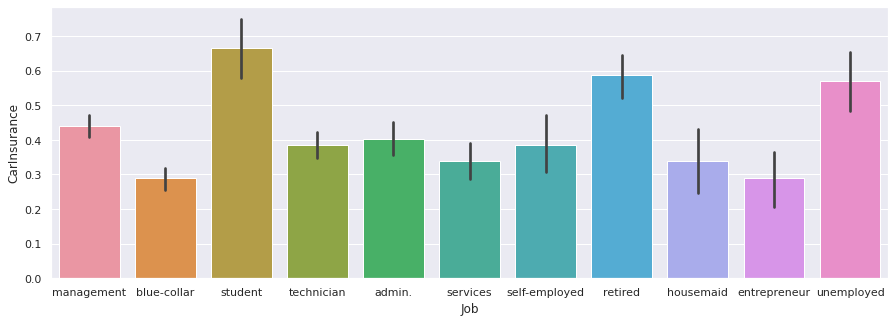

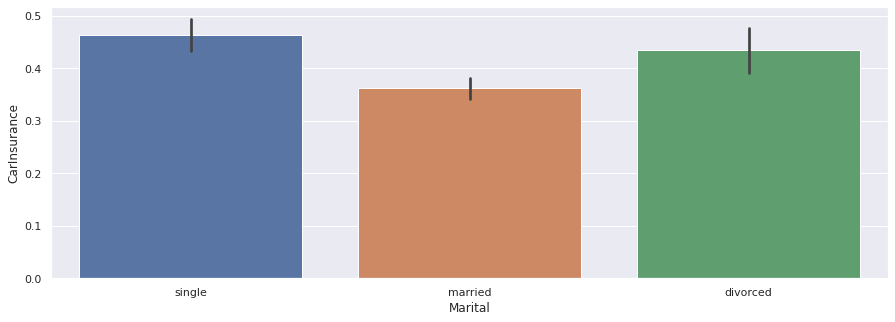

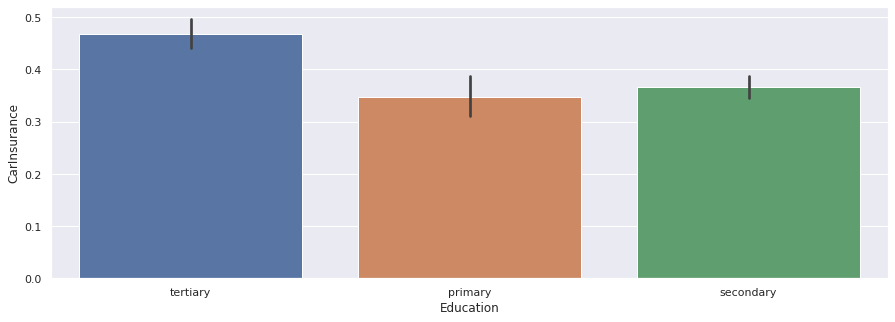

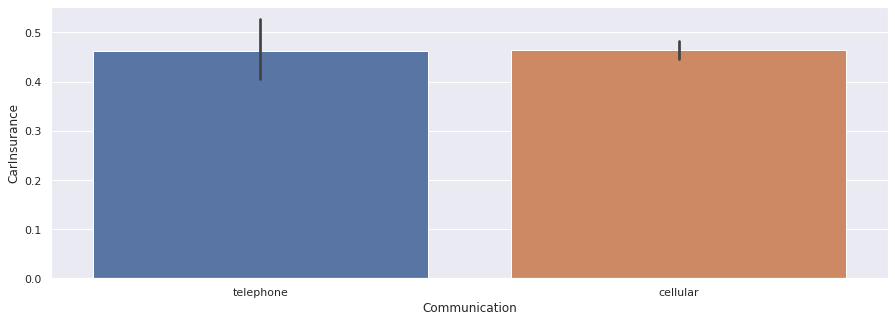

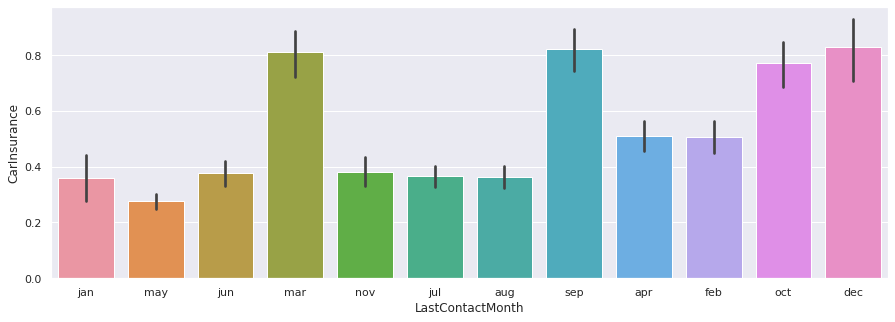

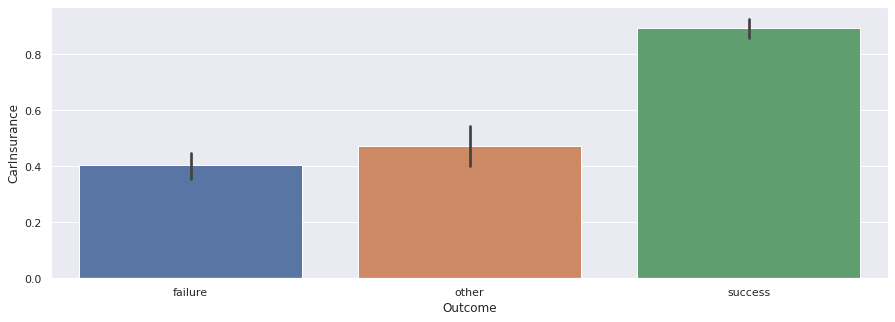

In [17]:
# examine the categorical features
for col in df_cat2.columns:
    plt.figure(figsize=(15,5))
    sns.barplot(x = col, y = 'CarInsurance', data=df_train) 

In [32]:
# check if communication var is worth keeping
# typically, if we have many variables, this would be an automated test, running through all stats that would output a list of significant vars
# worth keeping for model build
group_data = df_train.groupby(['CarInsurance', 'Communication']).size().unstack('CarInsurance')
chisq_stats, chisq_pvalue, chisq_dof, chisq_expctd = chi2_contingency(group_data.fillna(0))
print('The chi-square value for Communication and CarInsurance is {} and the p-value is {}'.format(chisq_stats, chisq_pvalue))

The chi-square value for Communication and CarInsurance is 0.0004371138594676448 and the p-value is 0.9833196287856788


## Exploratory Data Analysis - Summary (TL;DR)
Below is a summary of findings and actions from EDA
- The target variable, CarInsurance, is imbalanced. **Action:** consider over and undersampling to create a more balanced class
- One training obs was removed due to extremely high values in `Balance`. **Action:** none - already removed
- There are missing values `Outcome`, `Job`, `Education` and `Communication`. **Action:** consider imputation strategies

**Numeric vars:** 
1. There were weak positive and negative relationships with the target. **Action:** consider feature engineering to build more powerful features 
2. There are binary variables in the numerical data - `Default`, `HHInsurance`, `CarLoan` **Action:** convert to binary
3. DaysPassed and PrevAttempts are linearly correlated. **Action:** consider dropping of the cols and binning this numeric column to capture information regarding no previous contacts made

**Categorical vars:** 
1. The categorical variables will need to be encoded (one hot, numerical or otherwise) for model build. **Action:** consider encoding best practices for each categorical variable
2. `Communication` has no relationship with the target **Action:** drop this variable

In [19]:
# TODO: comment on categorical plots
# add to summary of eda
# start model building